#Gather trajectories

In [1]:
import numpy as np
import process_data
process_data = reload(process_data)
folder = '../annotations/coupa/video2/'
fname = folder + 'annotations.txt'
x_raw,y_raw = process_data.get_trajectories(fname,label="Biker")

from PIL import Image
fname = folder + 'reference.jpg'
im = Image.open(fname)
width,height = im.size
print "width = %f, height = %f" % (width,height)
x_transformed = map( lambda x: x-width/2 , x_raw )
y_transformed = map( lambda x: -height/2-x , y_raw )

width = 1980.000000, height = 1093.000000


#Clean trajectories
The heads and tails need to be chopped.  The data there is fallacious.

In [13]:
def truncate(x_in, y_in):
    assert( len(x_in) == len(y_in) )
    tol = 2.0
    n = 0
    while x_in[n:n+5].std()**2 + y_in[n:n+5].std()**2 < tol:
        n +=5
    n+=5
    m = len(x_in)
    while x_in[m-5:m].std()**2 + y_in[m-5:m].std()**2 < tol:
        m -=5
    m-=5
    return x_in[n:m], y_in[n:m]

x_clean,y_clean = zip( * map( lambda arg: truncate( *arg) , zip(x_transformed,y_transformed) ) )

In [14]:
from matplotlib import pyplot as plt
%matplotlib inline

(-1000.0, 1000.0, -600.0, 600.0)

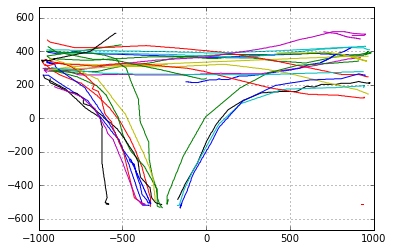

In [15]:
for k in range(len(x_clean)):
    plt.plot(x_clean[k],y_clean[k])
plt.grid()
plt.axis('equal')

## Cost function
For any two points $x_0,x_T$ we let $x(t;\theta)$ denote the curve on $[0,T]$ which minimizes the action
$$
    S[x;\theta] := \int_0^T L_\theta( x,\dot{x}) dt
$$
In otherwords, $x( \cdot \,;\theta) = {\rm argmin}_y( S[y;\theta] ) $.
Our goal is to learn the parameters, $\theta$.
Given a single curve $X:[0,T]\to D$, the cost function for our learning algorithm will be
$$
    C(\theta) = \frac{1}{2} \int_0^T \| X(t) - x(t;X_0,X_T,\theta) \|^2 dt
$$
so that the gradient is
$$
    dC(\theta) = - \int \langle X(t) - x(t;\theta) , \delta_\theta x(t;\theta) \rangle dt
$$
where $\delta_\theta x(t;\theta)$ solves the boundary value problem
$$
    \ddot{x} = - \nabla V(x;\theta) \quad , \frac{d^2}{dt^2} \delta_\theta x = - \delta_\theta \nabla V(x;\theta) \delta_\theta x
$$
with the boundary conditions $x(0),x(T)$ given and $\delta_\theta x(0) = \delta_\theta x(T) = 0$.

##Collocation method
Let's solve the nonlinear optimization problem:
Minimize
$$
    C(\theta,q) = \sum_{t = 0}^{N} \| q_{\rm obs}(t) - q(t) \|^2
$$
subject to the constraint $q(0) = q_{\rm obs}(0),q(N) = q_{\rm obs}(N)$ fixed and
$$
    \frac{q(i-1) - 2 q(i) + q(i+1)}{2} + \nabla V_\theta( q(i) ) = 0.
$$
for $i=1,\dots,N-1$

## Training in a Hermite Polynomial Basis
In this section we consider potential functions of the form
$$
    V(x,y) = \sum_{k_1,k_2=0}^{K} \theta[k_1,k_2] H_{k_1}(x) H_{k_2}(y)
$$
where $H_k$ is the $k$th Hermite polynomial.
The gradients of $V$ is given by
$$
    \partial_x V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_1 H_{k_1-1}(x) H_{k_2}(y) \\
    \partial_y V(x,y) = 2 \sum_{k_1,k_2}^K \theta[k_1,k_2] k_2 H_{k_1}(x) H_{k_2-1}(y) \\
$$

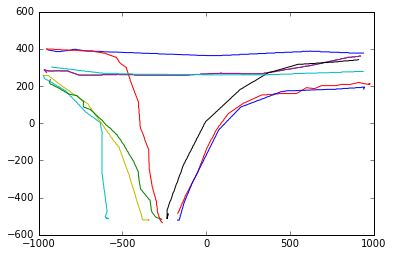

In [16]:
curve_indices = [0,4,6,13,4,14,15,17,20,22,24]
curves = []
for k in curve_indices:
    curves.append( np.vstack( [x_clean[k], y_clean[k]] ) )
    plt.plot( x_clean[k], y_clean[k])

In [19]:
curves = [ np.vstack([x_transformed[0][460:800:10], y_transformed[0][460:800:10]]) ]
curves.append( np.vstack( [ x_transformed[4][230:510:10],y_transformed[4][230:510:10] ] ) )
curves.append( np.vstack( [ x_transformed[6][290:580:10],y_transformed[6][290:580:10] ] ) )
curves.append( np.vstack( [ x_transformed[13][170:300:10],y_transformed[13][170:300:10] ] ) )
curves.append( np.vstack( [ x_transformed[14][420:580:10], y_transformed[14][420:580:10] ] ) )
curves.append( np.vstack( [ x_transformed[15][50:200:10],y_transformed[15][50:200:10] ] ) )
curves.append( np.vstack( [ x_transformed[17][400:680:10],y_transformed[17][400:680:10] ] ) )
curves.append( np.vstack( [ x_transformed[20][200:400:10],y_transformed[20][200:400:10] ] ) )
curves.append( np.vstack( [ x_transformed[22][370:650:10],y_transformed[22][370:650:10] ] ) )
curves.append( np.vstack( [ x_transformed[24][350:650:10],y_transformed[24][350:650:10] ] ) )

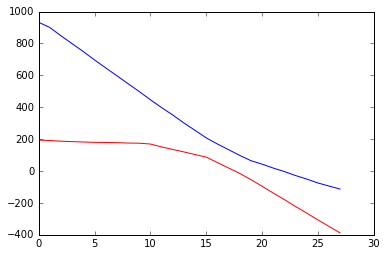

In [20]:
plt.plot(curves[6][0,:],'b-')
plt.plot(curves[6][1,:],'r-')

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
3229494.35777
[  0.00000000e+00  -1.13686838e-13   2.27373675e-13  -2.27373675e-13
   1.13686838e-13   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00  -1.13686838e-13   1.13686838e-13
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00  -1.13686838e-13
   2.27373675e-13  -2.27373675e-13   0.00000000e+00   2.27373675e-13
  -2.27373675e-13   2.27373675e-13  -2.27373675e-13   2.27373675e-13
  -2.27373675e-13   2.27373675e-13  -2.27373675e-13   0.00000000e+00
  -5.68434189e-14   5.68434189e-14  -5.68434189e-14   5.68434189e-14
  -5.68434189e-14   5.68434189e-14  -5.68434189e-14   5.68434189e-14
  -5.68434189e-14   5.68434189e-14  -5.68434189e-14   5.68434189e-14
  -5.68434189e-14   5.68434189e-14  -5.68434189e-14   5.68434189e-14
  -5.68434189e-14   5.68434189e-14  -5.684

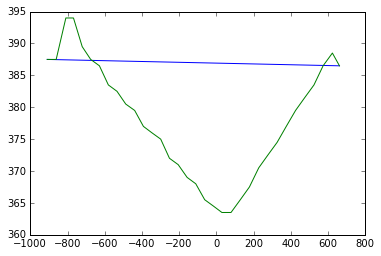

In [23]:
def get_xy_theta(decision_variables, curves , k_max ):
    x_list = []
    y_list = []
    ref = 0
    for curve in curves:
        n = curve.shape[1] #number of collocation points
        x_list.append( decision_variables[ref:ref+n] )
        y_list.append( decision_variables[ref+n:ref+2*n] )
        ref += 2*n
    theta = decision_variables[ ref:].reshape( (k_max+1,k_max+1) )
    return x_list,y_list,theta

def cost_function(decision_variables, curves , k_max ):
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out = 0.
    for x,y,c in zip( x_list, y_list, curves):
        out += np.dot(x-c[0],x-c[0]) + np.dot(y-c[1],y-c[1])
    return out

def EL_constraint(decision_variables , curves, k_max ):
    global width,height
    from scipy import sparse
    x_list,y_list,theta = get_xy_theta( decision_variables , curves , k_max)
    out_list = []
    k = np.arange(-k_max , k_max+1)
    for x,y in zip(x_list,y_list):
        n = x.size
        A_matrix = sparse.diags([np.ones(n-2),-2*np.ones(n-1),np.ones(n-2)],
                            offsets=[0,1,2], shape=(n-2,n) )
        a_x = A_matrix.dot( x)
        a_y = A_matrix.dot( y)
        from numpy.polynomial.hermite import hermder, hermval2d
        theta_x = hermder( theta, m=1, axis=0 )
        theta_y = hermder( theta, m=1, axis=1 )
        alpha_x = np.sqrt(2*k_max) / (width/2)
        alpha_y = np.sqrt(2*k_max) / (height/2)
        V_x = alpha_x*hermval2d( alpha_x*x[1:n-1], alpha_y*y[1:n-1], theta_x )
        V_y = alpha_y*hermval2d( alpha_x*x[1:n-1], alpha_y*y[1:n-1], theta_y )
        out_list += [a_x+V_x, a_y+V_y]
    return np.hstack( out_list )

def boundary_constraint(decision_variables , curves , k_max):
    x_list,y_list,_ = get_xy_theta( decision_variables, curves, k_max)
    n_curves = len(curves)
    out = np.zeros( (4,n_curves) )
    for k,(x,y) in enumerate( zip(x_list,y_list) ):
        out[0][k] = curves[k][0,0] - x[0]
        out[1][k] = curves[k][0,-1] - x[-1]
        out[2][k] = curves[k][1,0] - y[0]
        out[3][k] = curves[k][1,-1] - y[-1]
    return out.flatten()

k_max = 4
constraint_list = []
constraint_list.append({'type':'eq', 'fun':EL_constraint, 'args':(curves,k_max)} )
constraint_list.append({'type':'eq', 'fun':boundary_constraint, 'args':(curves,k_max) } )

theta = np.zeros( (k_max+1, k_max+1) )
guess_list = []
for c in curves:
    x_guess = np.linspace(c[0,0],c[0,-1], len(c[0]))
    y_guess = np.linspace(c[1,0],c[1,-1], len(c[1]))
    guess_list += [x_guess,y_guess]
initial_guess = np.hstack( guess_list + [theta.flatten(),] )

def cb_function(x):
    global k_max,curves
    print "Cost = %f" % cost_function(x, curves , k_max )
    return 0

x_out,y_out,theta_out = get_xy_theta( initial_guess , curves, k_max)
plt.plot(x_out[0],y_out[0])
plt.plot(curves[0][0,:],curves[0][1,:])
print theta_out
print cost_function(initial_guess, curves, k_max)
print EL_constraint(initial_guess, curves, k_max)
print boundary_constraint(initial_guess, curves, k_max)
print cb_function(initial_guess)

In [24]:
from scipy.optimize import minimize
res = minimize( cost_function , initial_guess , constraints=constraint_list , args = (curves, k_max ),
              callback = cb_function)
print res.message
x_list,y_list,theta_opt = get_xy_theta( res.x , curves, k_max)

Cost = 3176984.521038
Cost = 290967.947148
Cost = 237772.312371
Cost = 229311.687582
Cost = 229845.828264
Cost = 227196.836038
Cost = 219340.444415
Cost = 205274.592001
Cost = 193179.912259
Cost = 185570.276286
Cost = 183270.375761
Cost = 182952.098039
Cost = 182698.941236
Cost = 182585.635161
Cost = 182511.321236
Cost = 182494.837275
Cost = 182489.198062
Cost = 182488.606717
Cost = 182488.551686
Cost = 182488.547972
Cost = 182488.547234
Cost = 182490.213912
Cost = 182488.547207
Cost = 182488.546996
Cost = 182488.547491
Cost = 182488.561624
Cost = 182488.547183
Cost = 182488.547125
Cost = 182488.547277
Cost = 182488.547199
Cost = 182488.547187
Cost = 182488.547123
Cost = 182488.547209
Cost = 182488.547155
Cost = 182488.547905
Cost = 182488.547124
Cost = 182488.547103
Cost = 182488.547125
Cost = 182488.549109
Optimization terminated successfully.


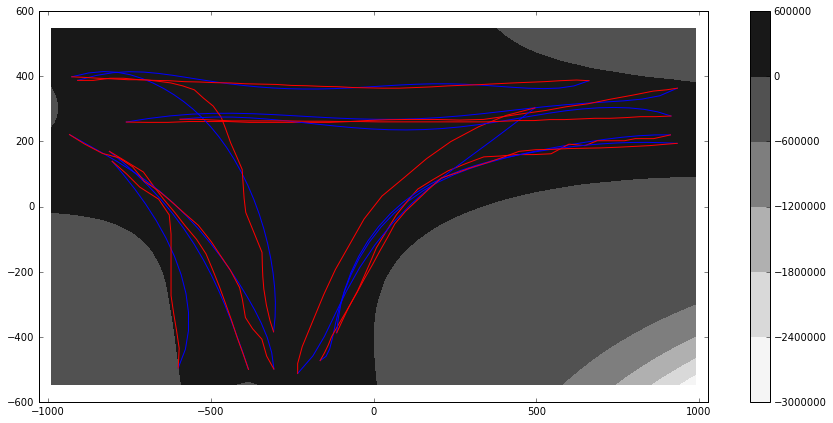

In [34]:
x_grid,y_grid = np.meshgrid( np.linspace(-width/2,width/2,50) , np.linspace(-height/2,height/2,50))
n_curves = len(curves)
from numpy.polynomial.hermite import hermval2d
alpha_x = np.sqrt(2*k_max) / (width/2)
alpha_y = np.sqrt(2*k_max) / (height/2)
V = hermval2d(alpha_x*x_grid , alpha_y*y_grid, theta_opt)
fig = plt.figure(figsize=(15,7))
plt.contourf(x_grid,y_grid,V , 5,cmap='Greys')
plt.colorbar()
for k in range(n_curves):
    plt.plot(x_list[k],y_list[k], 'b-')
    plt.plot(curves[k][0,:] , curves[k][1,:],'r-')
axis_size= plt.axis('equal')

In [35]:
np.save('theta_opt',theta_opt)

## Sanity check
Let's see if we can reproduce the blue curves in the above plot using Stormer Verlet.

In [36]:
def Stormer_Verlet(x0,x1,y0,y1,t_max):
    from numpy.polynomial.hermite import hermder
    theta_opt_x = hermder( theta_opt, axis=0, m=1)
    theta_opt_y = hermder( theta_opt, axis=1, m=1)
    x_pred = [x0,x1]
    y_pred = [y0,y1]
    for _ in range(2,t_max):
        x0,x1 = x_pred[-2], x_pred[-1]
        y0,y1 = y_pred[-2], y_pred[-1]
        V_x = alpha_x*hermval2d(alpha_x*x1 , alpha_y*y1, theta_opt_x )
        V_y = alpha_y*hermval2d(alpha_x*x1 , alpha_y*y1, theta_opt_y )
        x_pred.append( 2*x1 - x0 - V_x )
        y_pred.append( 2*y1 - y0 - V_y )
    return np.array(x_pred),np.array(y_pred)

In [37]:
curve_ind = 9
x0,x1 = x_list[curve_ind][0], x_list[curve_ind][1]
y0,y1 = y_list[curve_ind][0], y_list[curve_ind][1]
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1, len(x_list[curve_ind]))

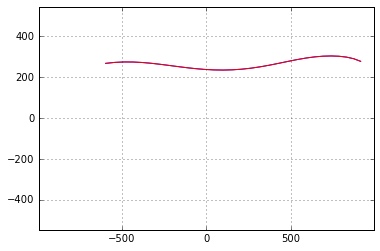

In [38]:
plt.plot(x_list[curve_ind],y_list[curve_ind],'b-')
plt.plot(x_pred,y_pred,'r-')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.grid(True)

## Predictions from Training Data
Now let's see if we can predict some of the red curves in the training data using a finite difference scheme to estimate the initial velocity

In [46]:
start = 2
x0 = curves[curve_ind][0,start]
x1 = x0 + 0.5*( curves[curve_ind][0,start+1] - curves[curve_ind][0,start-1] )
y0= curves[curve_ind][1,start]
y1 = y0 + 0.5*( curves[curve_ind][1,start+1] - curves[curve_ind][1,start-1] )
t_max = len(curves[curve_ind][0,:])
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max-start)

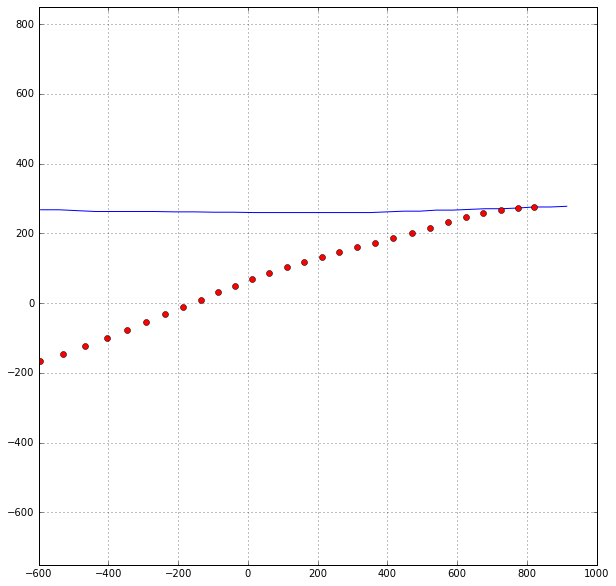

In [47]:
fig = plt.figure(figsize=(10,10))
plt.plot(curves[curve_ind][0],curves[curve_ind][1],'b-')
plt.plot(x_pred,y_pred,'ro')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.axis('equal')
plt.grid(True)

## Predictions on Test data
Let's do the same thing on some of the test data

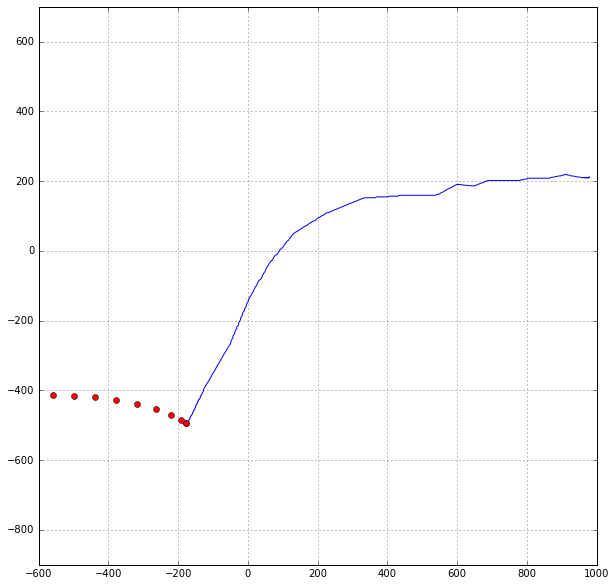

In [52]:
curve_ind = 6
start = 150
x0 = x_transformed[curve_ind][start]
x1 = x0 + ( x_transformed[curve_ind][start+3] - x_transformed[curve_ind][start-3] ) / float(6)
y0 = y_transformed[curve_ind][start]
y1 = y0 + ( y_transformed[curve_ind][start+3] - y_transformed[curve_ind][start-3] ) / float(6)
t_max = 10 #len(curves[curve_ind][0,:])-start
x_pred,y_pred = Stormer_Verlet(x0,x1,y0,y1,t_max)
fig = plt.figure(figsize=(10,10))
plt.plot(x_transformed[curve_ind], y_transformed[curve_ind],'b-')
plt.plot(x_pred,y_pred,'ro')
plt.axis([-width/2,width/2,-height/2,height/2])
plt.axis('equal')
plt.grid(True)